In [2]:
from __future__ import absolute_import, division, print_function

import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import shuffle
from RandomEnsembleClustering import RandomClusteringClassifier

%matplotlib inline
plt.style.use(["ggplot"])
plt.rcParams["figure.dpi"] = 120


In [3]:
## These functions are copied from "validateion_public_data.py" for clarity
def get_breast_cancer_data(test_size=0.5, random_state=None):
    """
    load data and split it into train and test set
    """
    x, y = load_breast_cancer(True)
    # reverse y (original y: 0: malignant, 1: benign.
    # but we want `malignant` to be the True class
    y = np.logical_not(y)
    train_x, test_x, train_y, test_y = (
        train_test_split(x, y, test_size=test_size, random_state=random_state))

    return train_x, train_y, test_x, test_y


def validate(data, n_probes=20, probes=None, n_estimators=50,
             probe_random_state=None, **kwargs):
    """

    Parameters
    ----------
    data: (train_x, train_y, test_x, test_y)
        the returned results from the get_breast_cancer_data() function.
        can also be data acquired else where passed in this order.
        If probes is provided, train_y won't be used (so it can be any
        arbitrary object)

    probes: array-like of shape = [n_probes, n_features], optional
        if probes are provided, use them to fit the model
        otherwise choose some from the data

    n_probes: integer, optional (default=20)
        number of probes to use to fit the model.
        if probes is not provided, randomly select n_probes sample in the
        true class for fitting the model.
        if probes is provided, this argument has no effect

    probe_random_state: integer, optional (default=None)
        The random state used for selecting probes. This probe_random_state is
        different from the random state for the RandomClusteringClassifier.
        The latter should be passed as a keyward argument `random_state`.
        This argument has no effect when probes is provided.

    **kwargs: keyword argument to be passed to the RandomClusteringClassifier.

    Return
    ------
    A dictionary of model, probes, and prediction results

    """

    train_x, train_y, test_x, test_y = data
    # if "probes" are not provided, get probes from train_x
    if probes is None:
        tr_true = train_x[train_y == 1]
        n_probes = min(n_probes, len(tr_true))
        probes = resample(tr_true, n_samples=n_probes, replace=False,
                          random_state=probe_random_state)

    n_probes = len(probes)
    # print out some conditions of the experiments
    n_unknown = len(train_x) - n_probes
    message = "Fitting {} models with {} 'True' samples and ".format(
              n_estimators, n_probes)
    message += "{} unlabelled samples \n".format(n_unknown)
    print(message)

    # initialize the RandomClusteringClassifier
    rcc = RandomClusteringClassifier(n_estimators=n_estimators, **kwargs)

    # fit the classifier using only train_x and probes (train_y is NOT used)
    # here train_x is the unlabelled data, probes are some known data in the
    # True class
    rcc.fit(train_x, probes)

    # predict on test_x, the test set that hasn't been seen by the rcc model
    pred = rcc.predict(test_x)
    proba = rcc.predict_proba(test_x)  # for other metrics

    print("="*30)
    print("\nValidating on {} samples in the test set\n\n".format(len(test_x)))
    print_results(test_y, pred)  # print out some test results

    return {"y_true": test_y,
            "y_pred": pred,
            "y_proba": proba,
            "probes": probes,
            "model": rcc}


def print_results(y_true, y_pred):
    """ Print out and plot some test results

    Parameters
    ----------
    y_true: array-like of shape = [n_test_samples]
        A boolean array of the actual classes (1: True)

    y_true: array-like of shape = [n_test_samples]
        A boolean array of the predicted classes
    """
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print("Accuracy: {:.2f} %".format(100 * accuracy_score(y_true, y_pred)))

    return


def plot_confusion_matrix(y_true, y_pred, labels=None,
                          add_title=True, norm=False):
    """
    Parameters
    ----------
    y_true: array-like of shape = [n_test_samples]
        A boolean array of the actual classes (1: True)

    y_true: array-like of shape = [n_test_samples]
        A boolean array of the predicted classes

    labels: label name of each class, optional (default None)
        if None, use [0, 1] as labels

    add_title: boolean, optional (default True)
        whether to add titles in the figure. title would be
        the accuracy, and the precision and recall of the `True` class

    norm: boolean, optional (default False)
        If True, plot normalized confusion matrix in which each cell
        will be normalized to the total counts in the actual class

    """
    cm = confusion_matrix(y_true, y_pred)
    labels = labels or range(len(cm))
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    if norm:
        cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
    # cmap = sns.cubehelix_palette(as_cmap=True, reverse=True)
    cmap = "Blues"
    plt.figure(dpi=80)

    fmt = "g" if not norm else ".3f"
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels,
                annot=True, fmt=fmt, annot_kws={"size": 14}, cmap=cmap)
    plt.xlabel("Predicted", size=16)
    plt.ylabel("Actual", size=16)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.yticks(rotation="horizontal")
    if add_title:
        plt.title("Accuracy: {:.2f}\nprecision: {:.2f}, recall: {:.2f}".format(
                  accuracy, precision, recall))
    plt.tight_layout()
    plt.show()

    return


## Test with one random set of probes

Fitting 300 models with 15 'True' samples and 269 unlabelled samples 

Model #  1  / 300
Model #  30  / 300
Model #  60  / 300
Model #  90  / 300
Model #  120  / 300
Model #  150  / 300
Model #  180  / 300
Model #  210  / 300
Model #  240  / 300
Model #  270  / 300
Model #  300  / 300

Validating on 285 samples in the test set


Confusion matrix:
[[175   4]
 [ 11  95]]
             precision    recall  f1-score   support

      False       0.94      0.98      0.96       179
       True       0.96      0.90      0.93       106

avg / total       0.95      0.95      0.95       285

Accuracy: 94.74 %


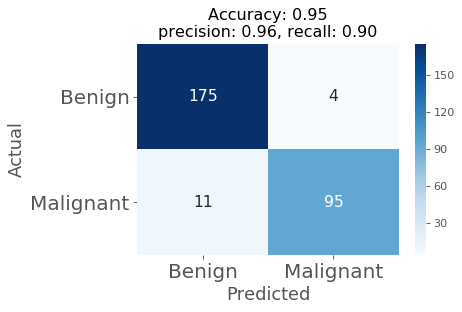

In [4]:
# get train and test data
# can change random_state and test_size to get different set of data 
data = get_breast_cancer_data(test_size=0.5, random_state=3)

# run a model and test it on the test set
res = validate(data, n_probes=15, probe_random_state=7,
               n_estimators=300, random_state=7, verbose=1)

# plot the confusion matrix for this experiment
plot_confusion_matrix(res["y_true"], res["y_pred"],
                      labels=["Benign", "Malignant"])
plt.show()

## Experiment: number of probes vs the test result

In [8]:
%%time

"""
Exp 1: n_probes vs std of accuracy
       Fix n_estimators, x_train, x_test, min_features, and max_features.
       test the results using different amount of n_probes (candidates_ns)
       for each n, run it n_probesets times (each tim with different probe set)
       
       for n in candidates_ns:
           for i in range(n_probesets):
               pre-select n probes (each time with different random state i)
               fit the model (with a fixed random_state) using x_train and probes
               obtain accuracy, recall, precision, and f-scores
           get distribution of these metrics
       
"""

train_x, train_y, test_x, test_y = get_breast_cancer_data(test_size=0.5, random_state=3)
tr_true = shuffle(train_x[train_y == 1], random_state=3)

candidate_ns = [1, 3, 5, 7, 11, 15, 25, 35]

# metrics of interest
accuracies, precisions, recalls, f1_scores = [], [], [], []

n_probesets = 10  # number of differnt sets of probes for the experiment

for n in candidate_ns:
    # metrics for this n (num of probes)
    acc, pre, rec, f1 = [], [], [], []
    print("=====Fitting models with n_probes = {}=====".format(n))
    for i in range(n_probesets):
        print("\t probe set {0:>2} / {1}".format(i+1, n_probesets))
        # pre-select probes (with random_state i)
        probes = resample(tr_true, n_samples=n, replace=False, random_state=i)
        
        # fit a RCC classifier using train_x and probes
        rcc = RandomClusteringClassifier(
            n_estimators=300, verbose=0, random_state=3, 
            max_features=5, min_features=2, n_jobs=-1)
        rcc.fit(train_x, probes)
        
        # predict on the testset and calculate some metrics
        pred =  rcc.predict(test_x)
        # proba = rcc.predict_proba(test_x)
        acc.append(accuracy_score(test_y, pred))
        pre.append(precision_score(test_y, pred))
        rec.append(recall_score(test_y, pred))
        f1.append(fbeta_score(test_y, pred, beta=1))
        gc.collect()
    
    accuracies.append(acc)
    precisions.append(pre)
    recalls.append(rec)
    f1_scores.append(f1)

# list -> np arrays
accuracies = np.array(accuracies)
precisions = np.array(precisions)
recalls = np.array(recalls)
f1_scores = np.array(f1_scores)

print("="*15 + "END" + "="*15)

=====Fitting models with n_probes = 1=====
	 probe set  1 / 10
	 probe set  2 / 10
	 probe set  3 / 10
	 probe set  4 / 10
	 probe set  5 / 10
	 probe set  6 / 10
	 probe set  7 / 10
	 probe set  8 / 10
	 probe set  9 / 10
	 probe set 10 / 10
=====Fitting models with n_probes = 3=====
	 probe set  1 / 10
	 probe set  2 / 10
	 probe set  3 / 10
	 probe set  4 / 10
	 probe set  5 / 10
	 probe set  6 / 10
	 probe set  7 / 10
	 probe set  8 / 10
	 probe set  9 / 10
	 probe set 10 / 10
=====Fitting models with n_probes = 5=====
	 probe set  1 / 10
	 probe set  2 / 10
	 probe set  3 / 10
	 probe set  4 / 10
	 probe set  5 / 10
	 probe set  6 / 10
	 probe set  7 / 10
	 probe set  8 / 10
	 probe set  9 / 10
	 probe set 10 / 10
=====Fitting models with n_probes = 7=====
	 probe set  1 / 10
	 probe set  2 / 10
	 probe set  3 / 10
	 probe set  4 / 10
	 probe set  5 / 10
	 probe set  6 / 10
	 probe set  7 / 10
	 probe set  8 / 10
	 probe set  9 / 10
	 probe set 10 / 10
=====Fitting models with n_p

### Plotting the results from the experiment

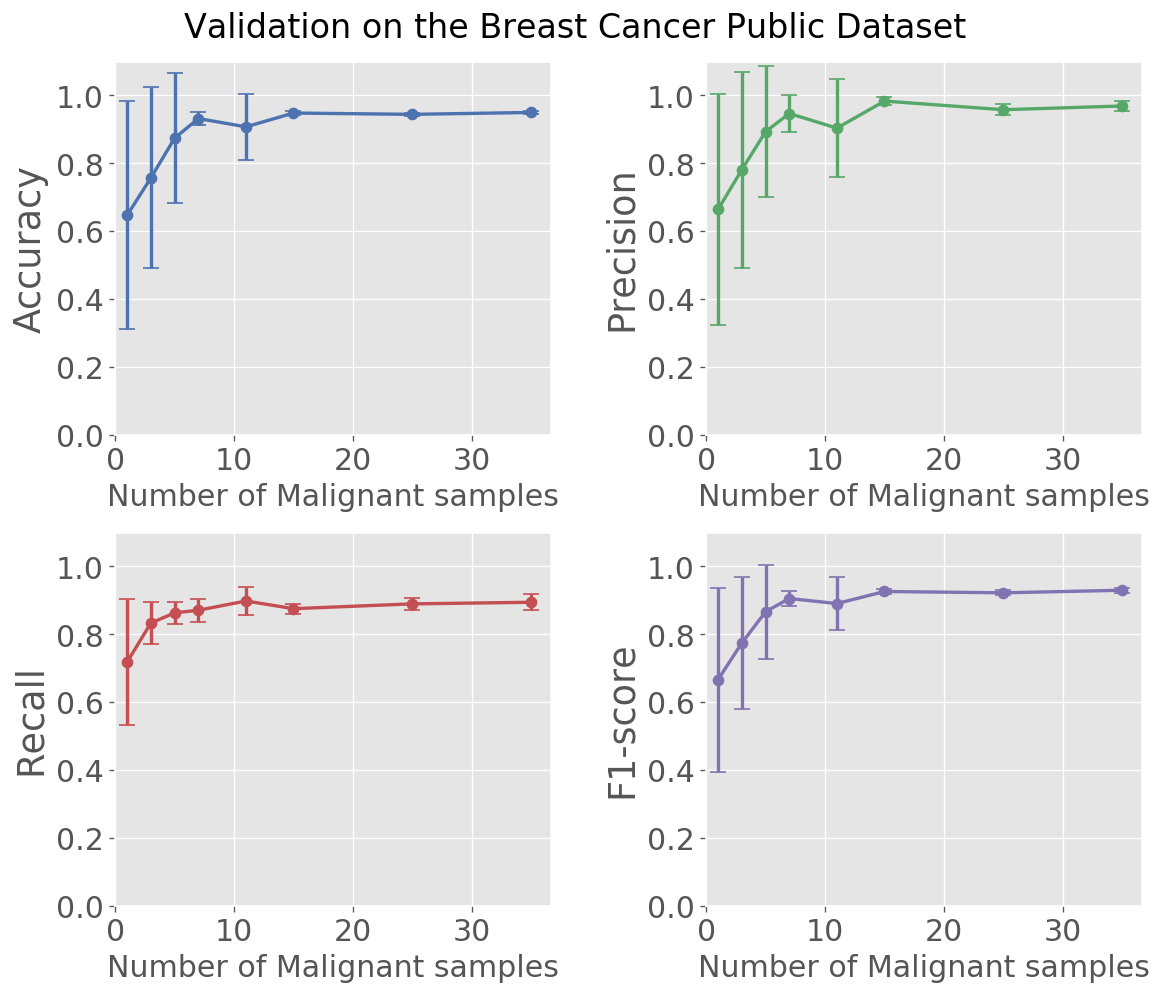

In [9]:
# init fig, 4 subplots with shared x and y
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8), dpi=120)
axes = [(0, 0), (0, 1), (1, 0), (1, 1)]  # coordinate of axis

# metrics (y) and their corresponding standard deviation (yerrs) and names
ys = [accuracies.mean(axis=1), precisions.mean(axis=1), recalls.mean(axis=1), f1_scores.mean(axis=1)]
yerrs = [accuracies.std(axis=1), precisions.std(axis=1), recalls.std(axis=1), f1_scores.std(axis=1)]
ylabels = ["Accuracy", "Precision", "Recall", "F1-score"]

# colors = ["yellow", "cyan", "lawngreen", "orange"]
colors = sns.color_palette("deep", 4)
errkw = {"fmt": "-o", "capsize": 5, "capthick": 1, "lw": 2}  # keyword arguments for errorbar plot

for (r, c), y, yerr, label, color in zip(axes, ys, yerrs, ylabels, colors):
    axis = ax[(r, c)] # current axis to plot
    # plot n vs metrics and their errorbars
    axis.errorbar(candidate_ns, y, yerr=yerr, color=color, **errkw)
    
    # fine tune figures
    axis.set_ylabel(label, size=22)
    axis.set_xlabel("Number of Malignant samples", size=18)
    plt.setp(axis.get_xticklabels(), visible=True)
    plt.setp(axis.get_yticklabels(), visible=True)
    axis.tick_params(labelsize=18)
    plt.xlim(0)

plt.ylim(0, 1.1)
plt.suptitle("Validation on the Breast Cancer Public Dataset", fontsize=20, y=1.03, color='k')
plt.tight_layout()